In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


In [3]:
path = '/kaggle/input/home-credit-default-risk/'
bureau_df = pd.read_csv(path + 'bureau.csv')
bureau_balance_df = pd.read_csv(path + 'bureau_balance.csv')

In [4]:
bureau_df.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


This table talks about the Loan data of each unique customer with all financial institutions other than Home Credit For each unique SK_ID_CURR we have multiple SK_ID_BUREAU Id's, each being a unique loan transaction from other financial institutions availed by the same customer and reported to the bureau.

In [5]:
bureau_df.nunique()

SK_ID_CURR                 305811
SK_ID_BUREAU              1716428
CREDIT_ACTIVE                   4
CREDIT_CURRENCY                 4
DAYS_CREDIT                  2923
CREDIT_DAY_OVERDUE            942
DAYS_CREDIT_ENDDATE         14096
DAYS_ENDDATE_FACT            2917
AMT_CREDIT_MAX_OVERDUE      68251
CNT_CREDIT_PROLONG             10
AMT_CREDIT_SUM             236708
AMT_CREDIT_SUM_DEBT        226537
AMT_CREDIT_SUM_LIMIT        51726
AMT_CREDIT_SUM_OVERDUE       1616
CREDIT_TYPE                    15
DAYS_CREDIT_UPDATE           2982
AMT_ANNUITY                 40321
dtype: int64

In [6]:
bureau_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [7]:
bureau_balance_df.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [8]:
bureau_balance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


### Checking missing value

In [9]:
def check_missing(df):
    total_miss = df.isnull().sum()
    miss_val_per = (total_miss/len(df)) * 100
    miss_table = pd.concat([total_miss, miss_val_per], axis=1)
    miss_table = miss_table[miss_table[0] != 0].rename(columns = {0:'Number missing Value', 1:'Percent'})
  
    return miss_table
    

In [10]:
check_missing(bureau_df)

,Number missing Value,Percent
DAYS_CREDIT_ENDDATE,105553,6.149573
DAYS_ENDDATE_FACT,633653,36.916958
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
AMT_CREDIT_SUM,13,0.000757
AMT_CREDIT_SUM_DEBT,257669,15.011932
AMT_CREDIT_SUM_LIMIT,591780,34.477415
AMT_ANNUITY,1226791,71.473490


In [11]:
check_missing(bureau_balance_df) #-> do not have missing value

,Number missing Value,Percent


### Bureau_df: Plot object features

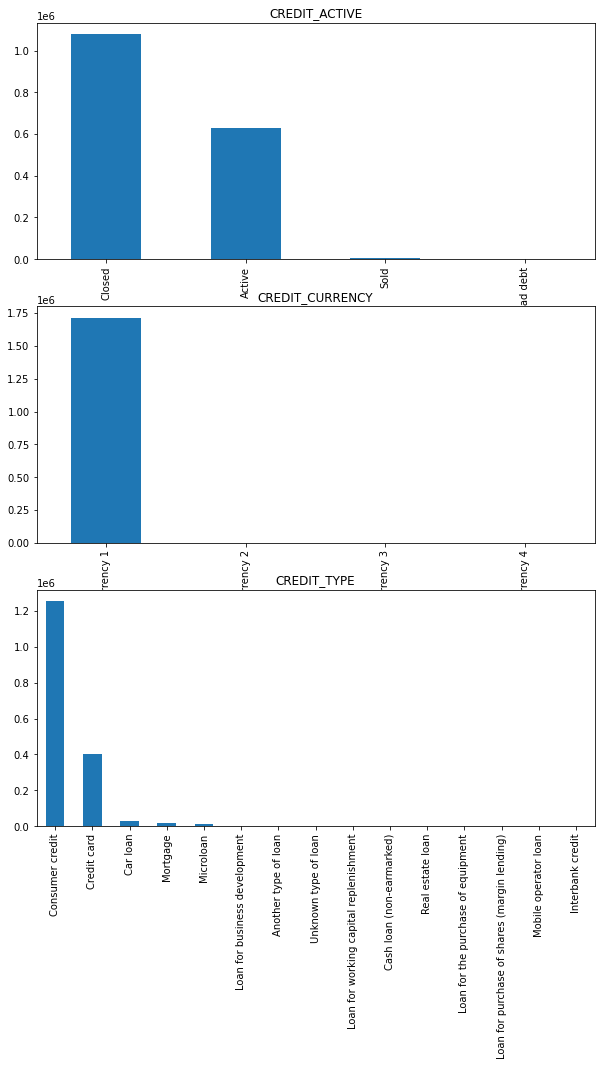

In [12]:
columns_obj = bureau_df.select_dtypes('object').columns
def plot_bar(cols):
    bureau_df[cols].value_counts().plot(kind='bar')

plt.figure(figsize = (10,20))    
for i in range(1, 4, 1):
    plt.subplot(4, 1, i)
    plot_bar(columns_obj[i-1])
    plt.title(columns_obj[i-1])

Comment: 
+ The majority of credits are either closed or active. 
+ One currency dominates all credits. Maybe its USD. 
+ The majority of loans are consumer credits or credit card. Then car loans and mortgage loans come after.

### Bureau_df: Plot numeric features

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


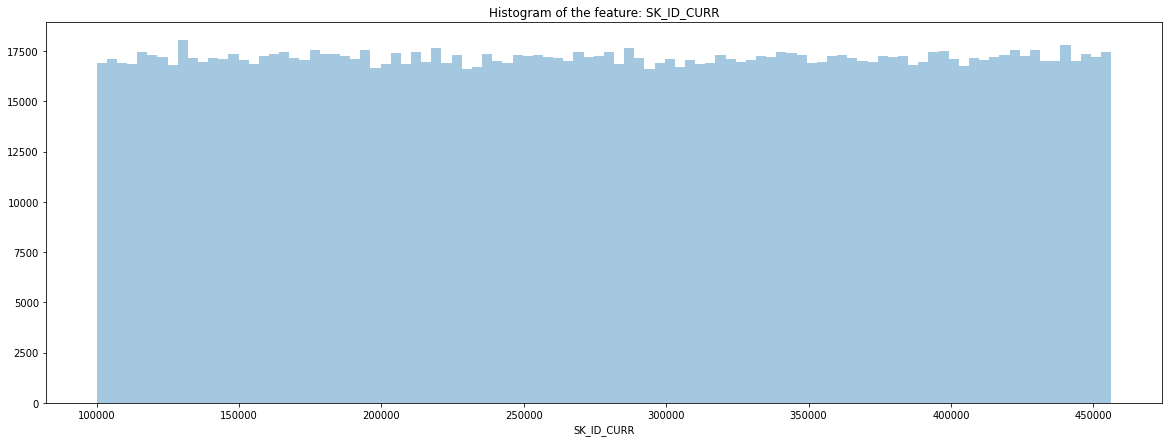

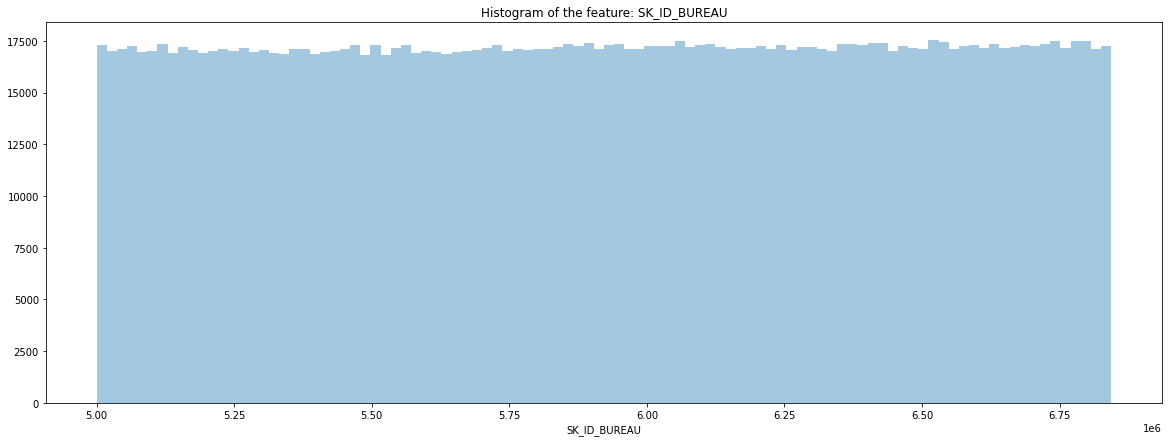

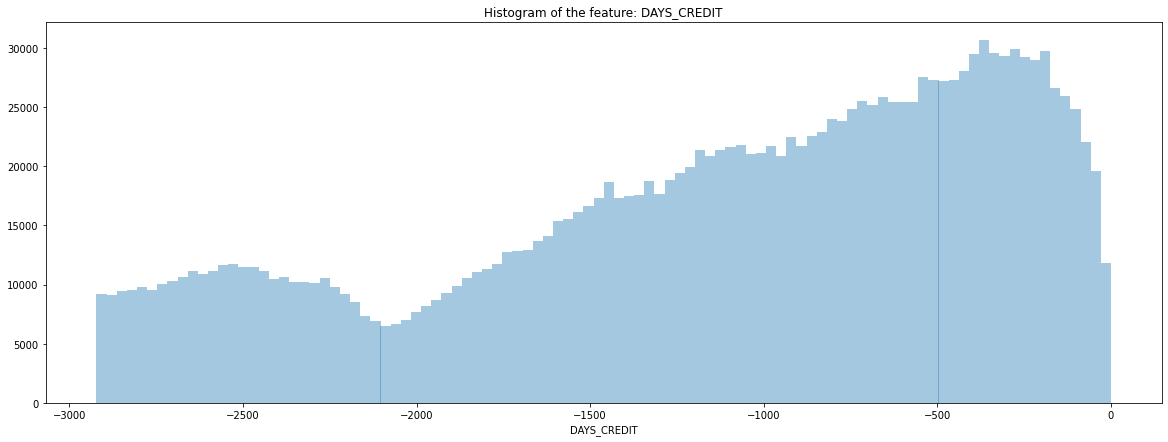

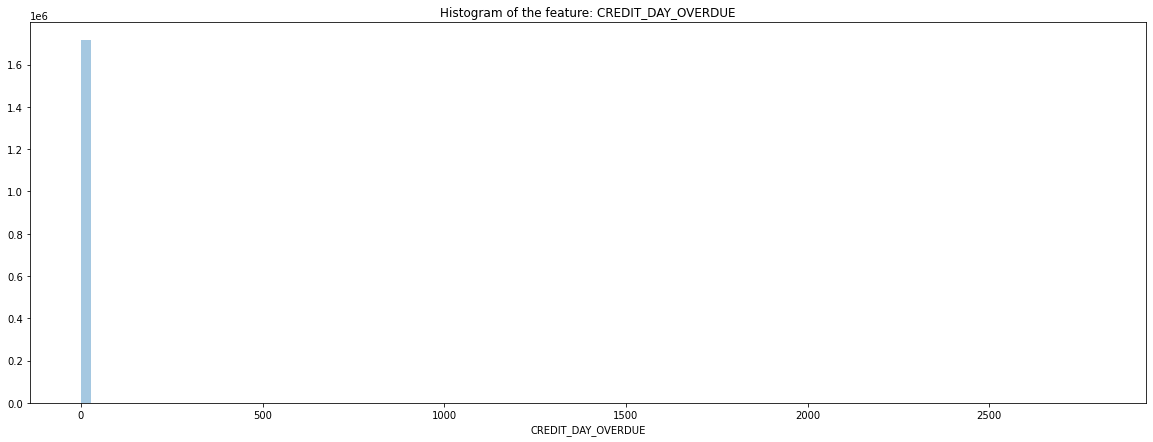

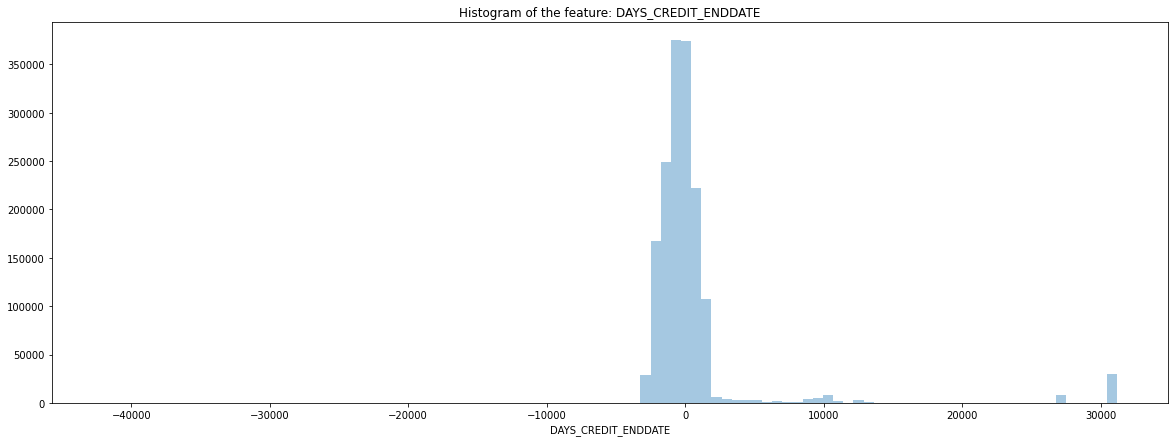

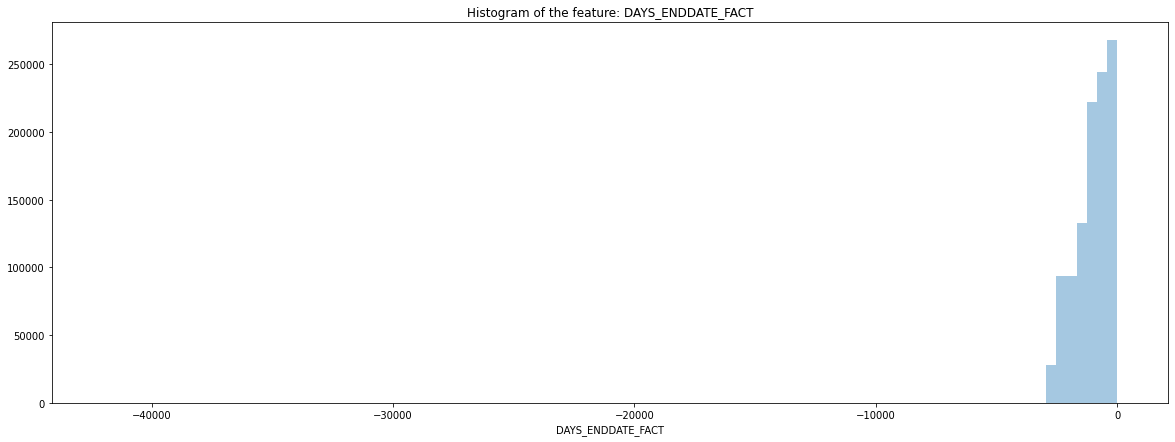

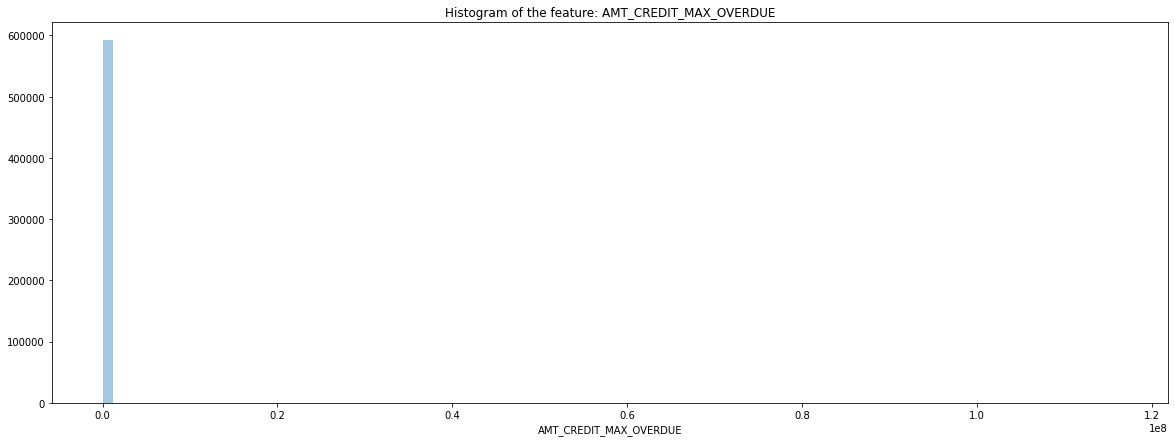

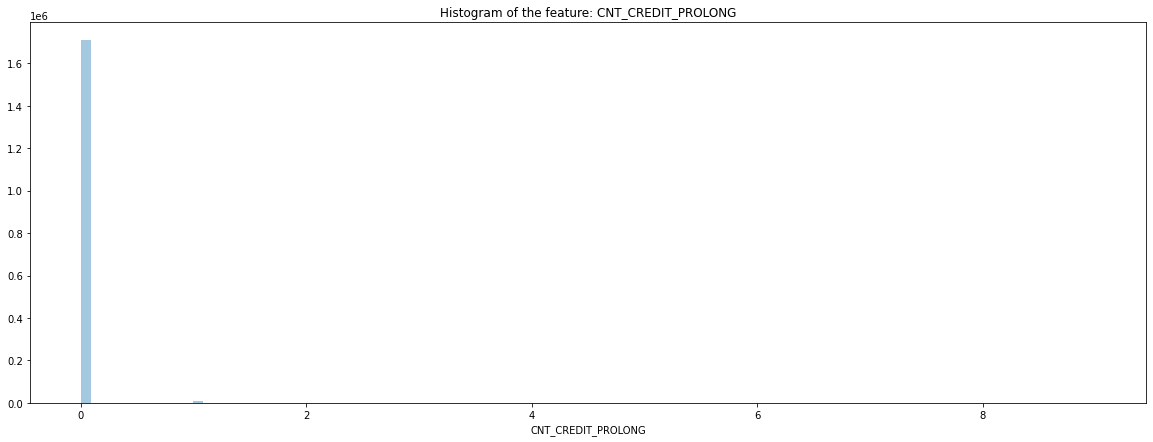

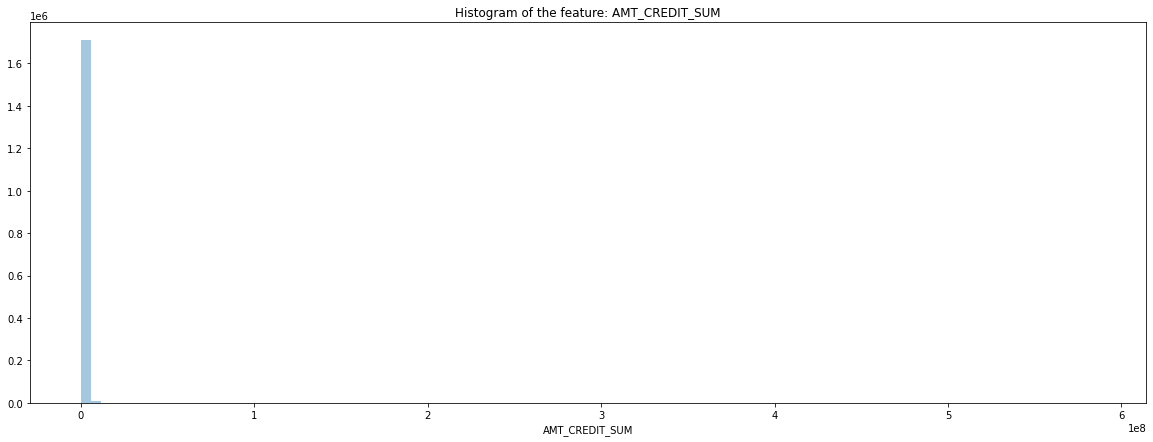

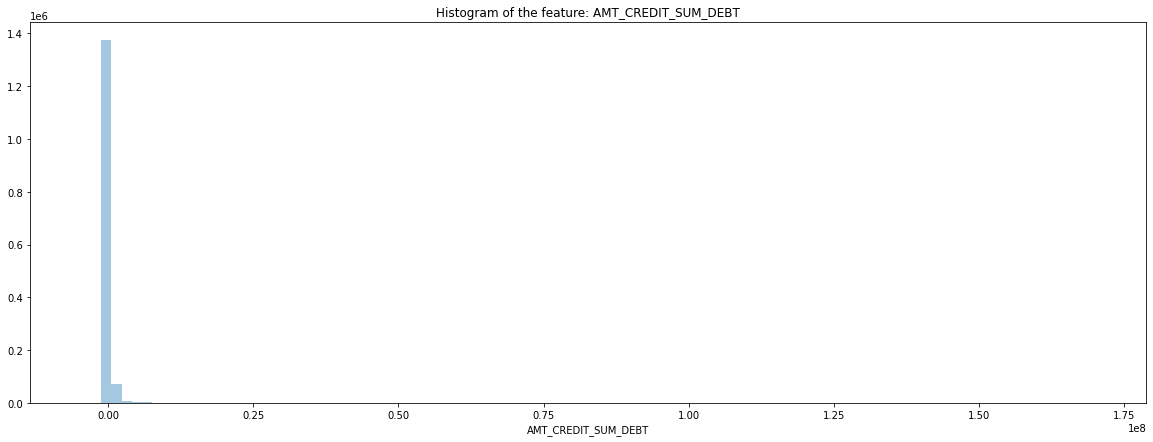

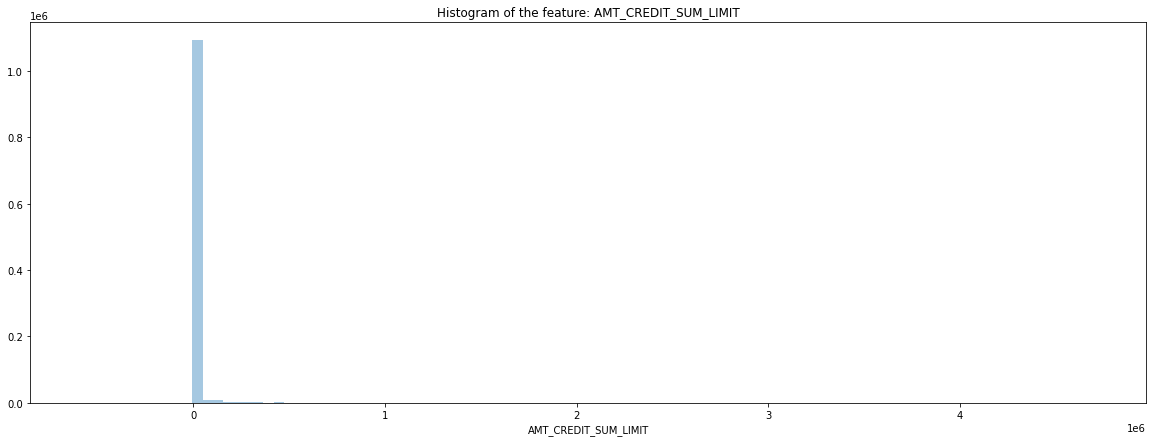

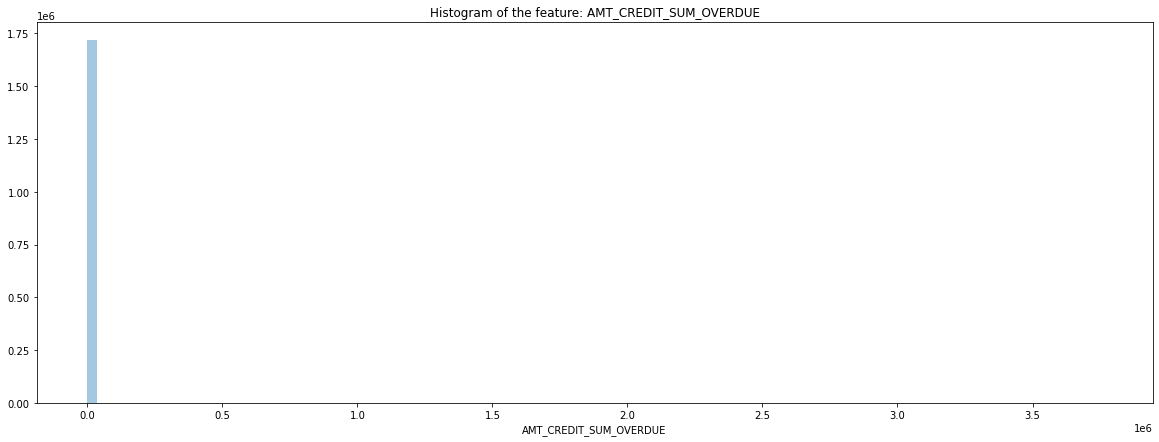

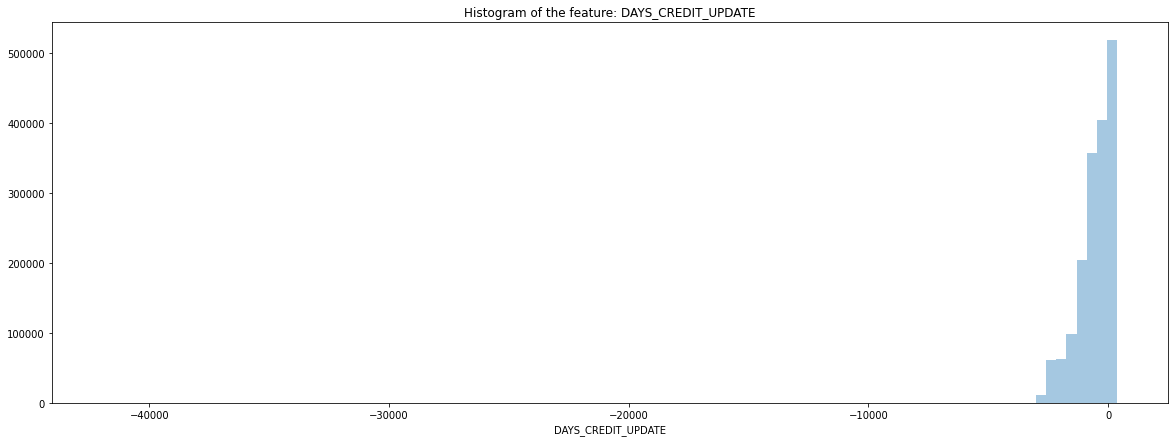

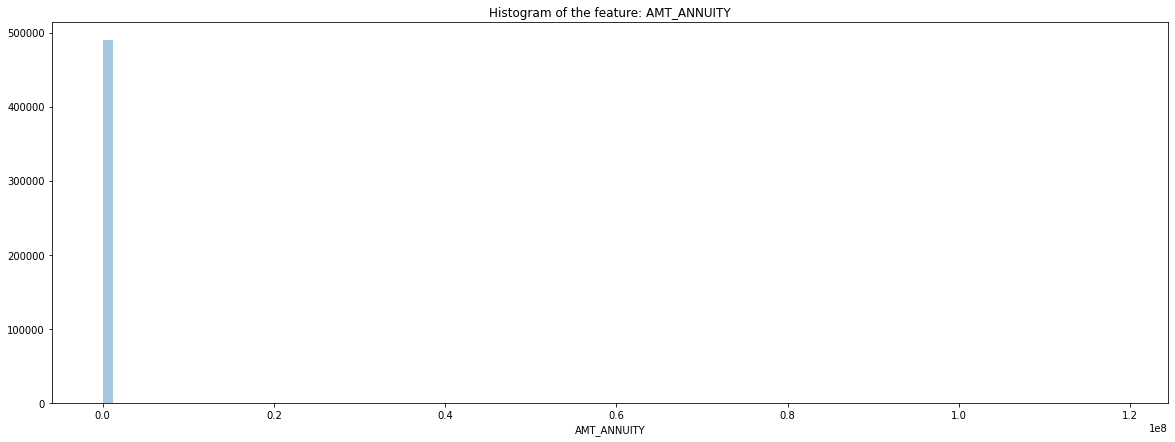

In [14]:
numeric_col = bureau_df.select_dtypes(exclude='object').columns
for feature in numeric_col:
    fig, ax = plt.subplots(1, 1, sharex = False, sharey = False, figsize = (20, 7))
    
    # Plot feature distribution
    sns.distplot(bureau_df[feature].dropna(), kde = False, bins = 100, ax = ax)
    ax.set_title("Histogram of the feature: " + feature)

Comment: They are a lot of outliers, especially for features: CREDIT_DAY_OVERDUE, AMT_CREDIT_SUM_DEBT, AMT_ANNUITY, AMT_CREDIT_SUM, DAYS_CREDIT_ENDDATE, AMT_CREDIT_SUM_LIMIT, CNT_CREDIT_PROLONG, DAYS_ENDDATE_FACT, AMT_CREDIT_SUM_OVERDUE, AMT_CREDIT_MAX_OVERDUE, DAYS_CREDIT_UPDATE


### Bureau_balance: Plot object features

<AxesSubplot:>

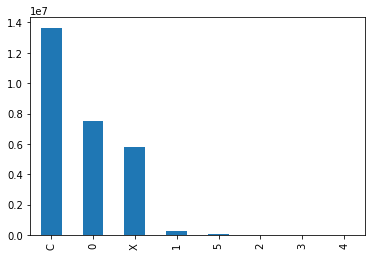

In [17]:
bureau_balance_df['STATUS'].value_counts().plot(kind='bar')

status c, o,x has high count 

### Bureau_balance: Plot numeric features

<AxesSubplot:xlabel='MONTHS_BALANCE', ylabel='Density'>

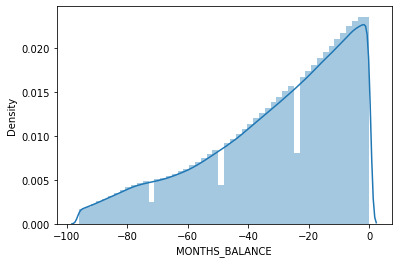

In [20]:
 sns.distplot(bureau_balance_df['MONTHS_BALANCE'].dropna())

In [33]:
merged_df = bureau_df.merge(bureau_balance_df, how = "left", on = "SK_ID_BUREAU")
merged_df.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE,STATUS
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN,NaN


In [35]:
corr = merged_df.drop(['SK_ID_BUREAU', 'SK_ID_CURR'], axis=1).corr()
corr

,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE
DAYS_CREDIT,1.000000,-0.021123,0.189360,0.825743,-0.011956,-0.022807,0.035303,0.115601,0.029514,0.002137,0.650718,0.011544,0.634931
CREDIT_DAY_OVERDUE,-0.021123,1.000000,-0.006470,-0.005059,0.000218,0.001214,-0.002405,-0.001295,-0.001461,0.019781,-0.018734,-0.000313,-0.013710
DAYS_CREDIT_ENDDATE,0.189360,-0.006470,1.000000,0.207567,0.003365,0.107875,0.042260,0.072996,0.150306,0.000816,0.267697,0.002259,0.120243
DAYS_ENDDATE_FACT,0.825743,-0.005059,0.207567,1.000000,0.004632,0.023027,0.055817,0.024838,0.018283,-0.000098,0.733722,0.010391,0.484183
AMT_CREDIT_MAX_OVERDUE,-0.011956,0.000218,0.003365,0.004632,1.000000,0.000473,0.111556,0.009679,-0.003287,0.006796,0.002451,0.002138,-0.007874
CNT_CREDIT_PROLONG,-0.022807,0.001214,0.107875,0.023027,0.000473,1.000000,-0.006097,0.001508,0.090151,-0.000159,0.028991,-0.000026,-0.017897
AMT_CREDIT_SUM,0.035303,-0.002405,0.042260,0.055817,0.111556,-0.006097,1.000000,0.694552,0.008485,0.004850,0.087246,0.047907,0.023397
AMT_CREDIT_SUM_DEBT,0.115601,-0.001295,0.072996,0.024838,0.009679,0.001508,0.694552,1.000000,-0.005466,0.007634,0.140044,0.021908,0.072998
AMT_CREDIT_SUM_LIMIT,0.029514,-0.001461,0.150306,0.018283,-0.003287,0.090151,0.008485,-0.005466,1.000000,-0.000478,0.090502,0.005117,0.019244
AMT_CREDIT_SUM_OVERDUE,0.002137,0.019781,0.000816,-0.000098,0.006796,-0.000159,0.004850,0.007634,-0.000478,1.000000,0.003440,0.000294,0.001720


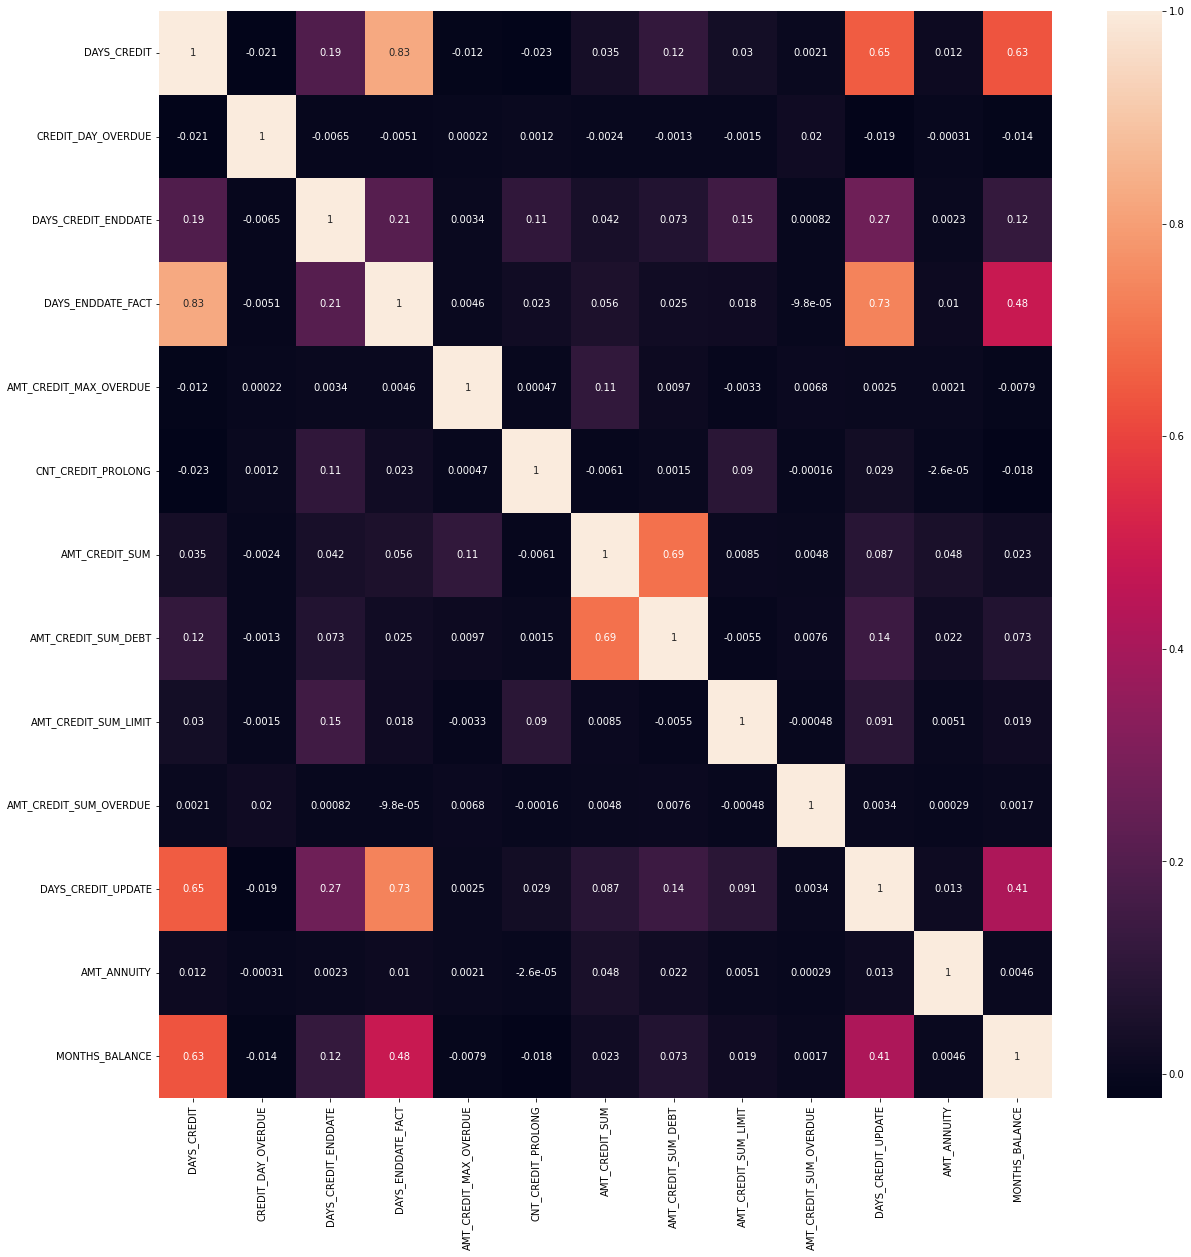

In [38]:
plt.figure(figsize = (20, 20))
corr_plot = sns.heatmap(corr, annot = True)